# Imports

In [1]:
1+1

2

In [1]:
import pandas as pd
import numpy as np
import math
from itertools import product
from tqdm.notebook import tqdm, trange
from matplotlib import pyplot as plt
from time import sleep
import os

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.dates import date2num, num2date
from collections import defaultdict
from scipy import stats
from collections import Counter
from typing import NamedTuple, List
from collections import deque

# to print dollars
import locale
locale.setlocale( locale.LC_ALL, '' )

'en_US.UTF-8'

In [2]:
df = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                 names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df.set_index('time', inplace=True)
df.index = pd.DatetimeIndex(df.index * 1e+9)

In [3]:
from dataclasses import dataclass
#@dataclass
class Score:
    def __init__(self, freq: float, num: int, predictor: list, response: int, apy: float=0.):
        self.freq = round(freq, 2)
        self.num = num
        self.predictor = predictor
        self.response = response
        self.apy = round(apy, 2)
        
    def __repr__(self):
        return (f'Score(apy={round(self.apy, 2)}, freq={round(self.freq, 2)}, num={self.num},'
                f'predictor={self.predictor}, response={self.response})')
    
    def __lt__(self, other):
        return (self.apy, self.freq, self.num) < (other.apy, other.freq, other.num)

# Trader1

In [4]:
class Trader1:
    # Bollinger: https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/#:~:text=Using%20the%20bands%20as%20overbought,have%20deviated%20from%20the%20mean.
    def __init__(self, n_cycles, n_devs, qty, take_at=0.005, fee=0.0026):
        # qty = quantity to trade at a time
        # EMA = Closing price x multiplier + EMA (previous day) x (1-multiplier)
        # 
        # BOLU=MA(TP,n)+m∗σ[TP,n]
        # BOLD=MA(TP,n)−m∗σ[TP,n]
        # where:
        # BOLU=Upper Bollinger Band
        # BOLD=Lower Bollinger Band
        # MA=Moving average
        # TP (typical price)=(High+Low+Close)÷3
        # n=Number of cycles in smoothing period ... n_cycles
        # m=Number of standard deviations ... n_devs
        # σ[TP,n]=Standard Deviation over last n periods of TP
        #
        # take_at = take profit at p0 * (1 + someting% + 2*fee)
        self.N = n_cycles
        self.M = n_devs
        self.qty = qty
        self.take_at = take_at
        self.fee = fee
        self.prices = np.array([0.] * self.N)
        
        self.sma = None
        self.upper = None
        self.lower = None
        self.var = None
        self.std = None
        self.open_price = None
        self.profit_price = None
        self.loss_price = None
    
        self.position = 0
        self.trades = []
        
        self.warming_up = True
        self.i = 0
    
    def update(self, cycle, ohlc: dict, price):
        _, high, low, close = self._unpack(ohlc)

        last_price = self.prices[self.i]
        self.prices[self.i] = price
        self.i += 1
        if self.i == len(self.prices):
            self.i = 0
            if self.warming_up:
                self.warming_up = False
                self.sma = np.mean(self.prices)
                self.var = np.var(self.prices)
                self.std = math.sqrt(self.var)
                self.upper = self.sma + self.M * self.std
                self.lower = self.sma - self.M * self.std
                return

        if not self.warming_up:
            old_sma = self.sma
            self.sma += (price - last_price) / self.N
            self.var += (price - self.sma + last_price - old_sma)*(price - last_price)/(self.N)
            self.var = self.check_var(self.var)
            self.std = math.sqrt(self.var)
            self.upper = self.sma + self.M * self.std
            self.lower = self.sma - self.M * self.std
            
    def check(self, x):
        if np.abs(x) > 0.01:
            raise
    
    def check_var(self, var):
        if var < 0:
            if abs(var) >= 1.e-4:
                raise Exception(f'var was {var}')
            return 0.
        return var
    
    def trade(self) -> float:  # return number of shares to trade
        if self.warming_up:
            return None
        price = self.prices[self.i]
        # buy
        if price < self.lower and self.position <= 0:
            if self.position == 0:
                self.open_price = price
                self.profit_price = price + self.take_at + 2*self.fee
                self.loss_price = price - (self.take_at + 2*self.fee)
            self.position += self.qty
            return self.qty
    
        # sell
        if price > self.upper and self.position >= 0:
            if self.position == 0:
                self.open_price = price
                self.loss_price = price + self.take_at + 2*self.fee
                self.profit_price = price - (self.take_at + 2*self.fee)
            self.position -= self.qty
            return -self.qty
        
        # profit
        if self.position > 0:
            if not self.loss_price <= price <= self.profit_price:
                self.position -= self.qty
                return -self.qty
        elif self.position < 0:
            if not self.profit_price <= price <= self.loss_price:
                self.position += self.qty
                return +self.qty
    
    @staticmethod
    def _unpack(ohlc: dict):
        return ohlc['open'], ohlc['high'], ohlc['low'], ohlc['close']

# DcatTrader

In [5]:
# Model that assumes we have aggregated information from the future
class DcatTrader:
    def __init__(self, window, actual_prices, take_min, qty, fee):
        self.y = self.get_y2(window, actual_prices)
        self.i = -1
        self.position = 0
        self.entry_price = 0
        self.price = 0
        self.take_min = take_min
        self.qty = qty
        self.fee = fee
        
    def update(self, _, __, price):
        self.i += 1
        self.price = price
        
        pass
    
    def trade(self):
        if np.isnan(self.y[self.i]):
            return
        
        # effective pnl% in terms of return r:
        #    pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
        #                 = r*(sign(q) - f) - 2*fee
        
        t = self.take_min
        f = self.fee
        if self.position == 0:
            r = self.y[self.i]
            
            is_good_buy = r >= (t+2*f)/(1-f)
            is_good_sell = r <= -(t+2*f)/(1+f)
        else:
            r = (self.price - self.entry_price)/self.entry_price
            
            is_good_buy = self.position < 0 and r <= -(t+2*f)/(1+f)
            is_good_sell = self.position > 0 and r >= (t+2*f)/(1-f)
            
        if is_good_buy:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position += self.qty  
            return self.qty
        elif is_good_sell:
            self.entry_price = self.price if self.position == 0 else np.nan
            self.position -= self.qty 
            return -self.qty          
            
        return 0
    
    def get_y2(self, w, prices):
                
        ma = prices.iloc[::-1].rolling(w).max()
        mi = prices.iloc[::-1].rolling(w).min()
        s = (ma + mi).iloc[::-1]
        return (.5*(s - 2.*prices)/prices)

# Pattern Trader

In [120]:
class PatternTrader:
    QTY = 0.01
    
    def __init__(self, price_increment: int,
                 patterns: List[Score],
                 budget=None):
        self.dp = price_increment
        self.patterns = patterns
        self.max_window = max(len(i.predictor) for i in patterns)
        self.ret_bps = deque()
        self.last_p = np.nan
        self.triggered = False  # True when cross 1% return
        
        self.position = 0
        
        self.cycle = None
        self.max_budget = budget
        self.current_budget = budget
        self.max_position = 0
        
        self.last_price = 0
        
        #self.debug_array = []
        
    def update(self, cycle, ohlc, price):
        self.last_price = price
        self.cycle = cycle
        log_p_bps = int(np.log(price) * 1e4)
        current_p = (log_p_bps // price_increment) * price_increment
        
        if not self.ret_bps or abs(current_p - self.last_p) >= price_increment:
            self.ret_bps.append(current_p - self.last_p)
            self.last_p = current_p
            
            self.triggered = True
            #print('Hey!!!!!!!!!!!!!')
        else:
            self.triggered = False

        if len(self.ret_bps) > self.max_window:
            self.ret_bps.popleft()
        
        #self.debug_array.append(self.current_budget)
        
        #if self.triggered:
        #    self.debug_array.append((cycle, current_p, self.ret_bps[-1]))
    
    def trade(self):
        r = self.ret_bps[-1]
        if self.triggered:
            prediction = self.predict(self.ret_bps, self.patterns)
            qty = np.sign(prediction) * self.QTY
            if np.sign(self.position) == -np.sign(qty):
                qty -= self.position
            
            if qty != 0:
                # TODO: add a method .update_position(qty)
                # that also update our dollar/crypto budget                    
                if self._check_budget(qty, self.last_price):
                    self._update_position(qty)
                    return qty
    
    def _update_position(self, qty) -> None:
        self.position += qty
        self.position = round(self.position, 6)
        if abs(self.position) > abs(self.max_position):
            self.max_position = self.position
    
    def _check_budget(self, qty, price):
        # Return if it has budget to trade, and if so, update the budget
        if self.max_budget:        
            q = qty
            p = self.position
            # Amazing formula, works for short and long
            after = self.current_budget + (abs(p) - abs(p + q))*price
            if after < 0:
                return False
            self.current_budget = after
            
        return True     
    
    #@staticmethod
    def predict(self, returns, best_scores):
        #print(f'Predicting: {self.ret_bps}')
        returns = tuple(returns)
        for s in best_scores:
            seq, prediction = s.predictor, s.response
            if len(returns) >= len(seq):
                if returns[-len(seq):] == seq:
                    return prediction    
        return 0

In [362]:
def trade(df, model):
    # model needs to have .update(cycle, ohlc) and trade()
    # return the trades

    trades = pd.Series(0., index=df.index)
    
    for i, (cycle, ohlc) in enumerate(df.iterrows()):
        model.update(cycle, ohlc, ohlc['close'])
        qty = model.trade()
        if qty:
            trades.iloc[i] = qty
    
#     # This is to make accounting easier
#     s = trades.sum()
#     if not np.isclose(s, 0.):
#         trades.iloc[-1] = -s
        
    return trades


def robustness(pnls, prices):
    # It should tell how much the model depends on the market
    returns = (prices.shift(-1) - prices)/prices
    idx = pnls != 0
    a = pnls[idx][:-1].corr(prices[idx][:-1])
    return 1 - a*a


def sharpe(pnls):
    return np.sum(pnls) / np.std(pnls)

def compute_pnl(prices, trades, fee):
    pos = trades.cumsum()
    d_pos = pos.abs().diff().fillna(abs(pos.iloc[0]))
    open_qty = (trades.abs() + d_pos)/2 * np.sign(trades)
    close_qty = (trades.abs() - d_pos)/2 * np.sign(trades)

    pos_id = (np.sign(pos.shift()) != np.sign(pos)).cumsum()
    open_sum = open_qty.groupby(pos_id).cumsum()
    open_mean = (prices * open_qty).groupby(pos_id).cumsum().div(open_sum).shift()

    p = (prices - open_mean) + (prices + open_mean) * fee * np.sign(close_qty)
    
    return -close_qty * p.fillna(0)    

def compute_accounting(prices, trades, fee=0.0026):

    #assert np.isclose(trades.sum(), 0.), 'Should not hold position at the end'
    assert prices.index.equals(trades.index)
    position = trades.cumsum()
    
    fees = (prices * trades * fee).abs()
    balance = -(prices * trades * (1 + np.sign(trades)*fee)).cumsum()
    book = prices * position * (1 - np.sign(position)*fee)
    
    total_cum = book + balance
    realized_pnl = compute_pnl(prices, trades, fee)
    
#to debug:    
#     return pd.DataFrame({'closed_pos': closed_pos, 'position': position,
#                         'prices': prices, 'trades': trades,
#                         'p*t':prices * trades, 'balance': balance,
#                         'book': book, 'unrealized': unrealized, 'pnl': pnl})
    return pd.DataFrame({'realized_pnl': realized_pnl,
                         'total_cum': total_cum,
                         'balance': balance,
                         'book': book,
                         'fees': fees},
                          index=prices.index)

def assert_equal(x, y):
    np.testing.assert_almost_equal(x, y)
#     if not (x == y):
#         raise AssertionError(f'x={x}, y={y}')

def test_pnl1():
    prices = pd.Series(range(11, 23), index=pd.date_range('20160606', periods=12))
    trades = pd.Series([0,1,0,2,0,-1,0,-1,0,-1,0,0], index=prices.index)
    a = compute_accounting(prices, trades, fee=0)
    assert_equal(a.realized_pnl.sum(), a.total_cum.iloc[-1])
    assert_equal(a.total_cum.iloc[-1], 14)  # -12 - 14*2 + 16 + 18 + 20
    assert_equal(len(a.realized_pnl[a.realized_pnl != 0]), 3)
    return a
    
def test_pnl2():    
    prices = pd.Series(range(11, 23), index=pd.date_range('20160606', periods=12))
    trades = pd.Series([0,1,0,-1,0,1,0,-1,-1,0,1,0], index=prices.index)
    a = compute_accounting(prices, trades, fee=0)
    assert a.realized_pnl.sum() == a.total_cum.iloc[-1]
    assert a.total_cum.iloc[-1] == 2  # -12 + 14 - 16 + 18 + 19 - 21
    assert len(a.realized_pnl[a.realized_pnl != 0]) == 3

def test_pnl3():    
    prices = pd.Series(reversed(range(11, 23)), index=pd.date_range('20160606', periods=12))
    trades = pd.Series([0,1,0,-1,0,1,0,-1,-1,0,1,0], index=prices.index)
    a = compute_accounting(prices, trades, fee=0)
    assert a.realized_pnl.sum() == a.total_cum.iloc[-1]
    assert a.total_cum.iloc[-1] == -2  # -12 + 14 - 16 + 18 + 19 - 21
    assert len(a.realized_pnl[a.realized_pnl != 0]) == 3

def test_pnl4():    
    prices = pd.Series(reversed(range(11, 23)), index=pd.date_range('20160606', periods=12))
    trades = -pd.Series([0,1,0,-1,0,1,0,-1,-1,0,1,0], index=prices.index)
    a = compute_accounting(prices, trades, fee=0)
    assert a.realized_pnl.sum() == a.total_cum.iloc[-1]
    assert a.total_cum.iloc[-1] == 2  # -12 + 14 - 16 + 18 + 19 - 21
    assert len(a.realized_pnl[a.realized_pnl != 0]) == 3

def test_pnl5():    
    prices = pd.Series([11,12,13,14,14])
    trades = pd.Series([1,-1,1,0,0])
    fee=1. # <----- ATTENTION ON THIS
    a = compute_accounting(prices, trades, fee=fee)
    assert a.total_cum.iloc[-1] == -48.
    assert len(a.realized_pnl[a.realized_pnl != 0]) == 1
    return a

def test_pnl6():
    prices = pd.Series(range(11, 23), index=pd.date_range('20160606', periods=12))
    trades = pd.Series([0,1,0,-2,0,+3,0,-4,0,+5,0,0], index=prices.index)
    a = compute_accounting(prices, trades, fee=0)
    assert a.realized_pnl.sum() + 3*(22-20) == a.total_cum.iloc[-1]
    assert a.total_cum.iloc[-1] == 6, a.total_cum.iloc[-1]  # -12 + 2*14  -3*16  +4*18  -5*20 +3*23
    assert len(a.realized_pnl[a.realized_pnl != 0]) == 4
    return a

def test_pnl7():    
    prices = pd.Series([11,12,13,14,15])
    trades = pd.Series([1,-3,0,3,0])
    fee=.123 # <----- ATTENTION ON THIS
    a = compute_accounting(prices, trades, fee=fee)
    assert_equal(a.total_cum.iloc[-1], -11*(1+fee) + 12*3*(1-fee) - 3*14*(1+fee) + 15*(1-fee))
    #assert len(a.pnl[a.pnl != 0]) == 1
    return a

def test_pnl8():    
    prices = pd.Series([10,11,12,13,14])
    trades = pd.Series([1,2,-1,-3,1])
    a = compute_accounting(prices, trades, fee=0.1)
    assert_equal(a.total_cum.iloc[-1], -4.7)
    #assert len(a.pnl[a.pnl != 0]) == 1
    return a

_ = test_pnl1()
_ = test_pnl2()
_ = test_pnl3()
_ = test_pnl4()
_ = test_pnl5()
a = test_pnl6()
a = test_pnl7()
a = test_pnl8()

# Run Sim

In [358]:
def dd(x):  # to print dollars
    return locale.currency(x, grouping=True)

In [359]:
%%time
trader = PatternTrader(100, best_score_max, budget=100)
trades = trade(df, trader)

CPU times: user 8.15 s, sys: 17.4 ms, total: 8.16 s
Wall time: 8.34 s


In [360]:
acc = compute_accounting(df.close, trades)
print(f'sharpe = {sharpe(acc.realized_pnl)}')
print(f'realized pnl = {dd(acc.realized_pnl.sum())}')
print(f'total pnl = {dd(acc.total_cum.iloc[-1])}')
print(f'balance = {dd(acc.balance.iloc[-1])}')
print(f'book = {dd(acc.book.iloc[-1])}')
apy_factor = 365 / (trades.index[-1] - trades.index[0]).days
print(f'pnl < 0={len(acc.realized_pnl[acc.realized_pnl < 0])}')
print(f'pnl > 0={len(acc.realized_pnl[acc.realized_pnl > 0])}')
print(f'# trades={len(trades[trades != 0])}')
print(f'fees={dd(acc.fees.sum())}')

#sharpe(acc.pnl), len(acc.pnl[acc.pnl < 0]), len(acc.pnl[acc.pnl > 0]), len(trades[trades != 0])

sharpe = -699.2084199128428
realized pnl = -$546.79
total pnl = -$554.34
balance = -$1,140.63
book = $586.29
pnl < 0=536
pnl > 0=408
# trades=945
fees=$1,392.43


In [343]:
2234.99 - 554.34, 1140.63 + 586.29

(1680.6499999999996, 1726.92)

<AxesSubplot:xlabel='time'>

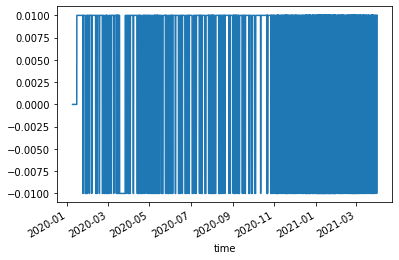

In [125]:
trades.cumsum().plot()

<AxesSubplot:xlabel='time'>

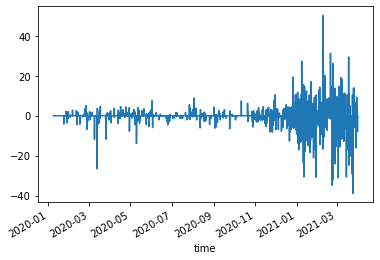

In [113]:
acc.pnl.plot()

In [135]:
trader.current_budget

279.3407001000105

In [136]:
trader.max_position

0.11

In [124]:
sum(trades)

0.07000000000000044

<AxesSubplot:xlabel='time'>

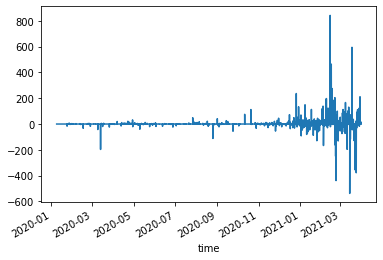

In [122]:
acc.pnl.plot()

In [493]:
b = trader.debug_prices

In [494]:
a = get_trend(prices)

In [495]:
len(a), len(b)

(16674, 16672)

In [506]:
b.tail()

,0,1,2
16667,2021-03-31 22:23:00,109800,100.0
16668,2021-03-31 23:00:00,109700,-100.0
16669,2021-03-31 23:10:00,109800,100.0
16670,2021-03-31 23:12:00,109700,-100.0
16671,2021-03-31 23:13:00,109800,100.0


In [507]:
a.tail()

,price,return
time,,
2021-03-31 22:23:00,109800,100
2021-03-31 23:00:00,109700,-100
2021-03-31 23:10:00,109800,100
2021-03-31 23:12:00,109700,-100
2021-03-31 23:13:00,109800,100


In [478]:
np.log(8217.51) * 10000

90140.22522452753

In [476]:
df.close

time
2020-01-08 15:29:00     8300.00
2020-01-08 15:33:00     8300.00
2020-01-08 16:09:00     8217.51
2020-01-08 16:20:00     8217.51
2020-01-08 17:43:00     7900.01
                         ...   
2021-03-31 23:39:00    58800.00
2021-03-31 23:41:00    58800.00
2021-03-31 23:42:00    58800.00
2021-03-31 23:50:00    58850.67
2021-03-31 23:52:00    58781.48
Name: close, Length: 80826, dtype: float64

In [212]:
len(trades[trades>0]), len(trades[trades<0])

(1741, 1741)

In [173]:
len(trades[trades != 0])

2231

In [ ]:
%%time
trades = trade(df, Trader1(10, 2, 0.002))
acc = compute_accounting(df, trades)
sharpe(acc.pnl), sharpe(acc.adjusted_pnl)

In [434]:
%%time
trades = trade(df, DcatTrader(75, actual_prices=df.close,
                              take_min=0.007, qty=0.002, fee=0.0026))
acc = compute_accounting(df.close, trades)
#rob = robustness(acc.pnl, df.close)
print(f'sharpe(acc.pnl)={sharpe(acc.pnl)}')
print(f'acc.pnl={acc.pnl.sum()}')
print(f'len(acc.pnl[acc.pnl < 0])={len(acc.pnl[acc.pnl < 0])}')
print(f'len(acc.pnl[acc.pnl > 0])={len(acc.pnl[acc.pnl > 0])}')
print(f'len(trades[trades != 0])={len(trades[trades != 0])}')# (6058.5075476589045, -8191.272070021878), (33, 1103)

sharpe(acc.pnl)=10028.055323091203
acc.pnl=1005.4595969483163
len(acc.pnl[acc.pnl < 0])=1
len(acc.pnl[acc.pnl > 0])=1921
len(trades[trades != 0])=3844
CPU times: user 7.05 s, sys: 12.9 ms, total: 7.06 s
Wall time: 7.11 s


In [ ]:
acc.pnl[acc.pnl < 0].head(1)

In [ ]:
r = -0.005
fee = 0.003
qty = -0.0002

# pnl/(p0*|q|) = r*sign(q) - fee*(2+r)
r*np.sign(qty) - fee*(2+r)

In [ ]:
for i in [30]:
    fee = 0.0001 * i
    print(fee, (0.005 + 2*fee)/(1-fee), -(0.005 + 2*fee)/(1+fee))

In [ ]:
0.010967098703888336 - fee * (2 -0.010967098703888336)

In [ ]:
(8652.87 * (1-0) - 8609.40 * (1+0))*0.002

In [ ]:
trades.loc['2020-02-17 16:50:00']

In [ ]:
prices.open['2020-02-17 16:50:00']

In [ ]:
a = pd.merge(trades, df, left_index=True, right_index=True)
a = pd.merge(a, acc, left_index=True, right_index=True)
a = a[a.qty!=0]

In [ ]:
b = a.query('time <= "2020-01-21 18:58:00" and time >= "2020-01-21 03:21:00"')
b

# Plotting

In [511]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as offline

def plot(df, trades):
    # df columns = ['open', 'high', 'low', 'close', 'volume', 'trades']
    # trades columns = ['qty']

    buys = df.open[trades > 0]
    sells = df.open[trades < 0]
    pnls = compute_accounting(df, trades).pnl
    pnls = pnls[pnls != 0]
    pnls = pnls.cumsum()
    
    trace = go.Scatter(
        x=df.index,
        y=df['open'],
        name='Tick'
    )

    trace2 = go.Scatter(
        x=buys.index,
        y=buys,
        #text=buys['order_id'],
        #hoverinfo='text',
        name='Buy',
        mode='markers',
        marker=dict(
            size=10,
            color='rgba(182, 255, 193, .9)',
            line=dict(
                width=2,
            )
        )
    )

    trace3 = go.Scatter(
        x=sells.index,
        y=sells,
        #text=sells['order_id'],
        #hoverinfo='text',
        name='Sell',
        mode='markers',
        marker=dict(
            size=7,
            color='rgba(255, 182, 193, .9)',
            line=dict(
                width=1,
            )
        )
    )

    trace4 = go.Scatter(
        x=pnls.index,
        y=pnls,
        name='P&L',
        mode='lines+markers',
        marker=dict(
            size=5,
            color='rgba(193, 182, 255, .9)',
            line=dict(
                width=1,
            )
        ),
        yaxis='y2'
    )
    
    data = [trace, trace2, trace3, trace4]
    layout = go.Layout(
        title='Trading log',
        yaxis=dict(
            title='Price'
        ),
        yaxis2=dict(
            title='BTC',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        ),
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        ),
        xaxis2=dict()
    )

    fig = go.Figure(data=data, layout=layout)
    offline.plot(fig, auto_open=True, filename=os.path.join('/Users/felipe/crypto/bitme2', 'results_plot.html'))
    # offline.iplot(fig)  #

    return 0

In [ ]:
plot(df, trades)

# Model research

In [ ]:
df = pd.read_csv('data/XBTUSDC_1.csv', header=None,
                     names=['time', 'open', 'high', 'low', 'close', 'volume', 'trades'])
df = df.set_index('time')
df.index = pd.DatetimeIndex(df.index * 1e+9)
#df = df.reindex(index=pd.date_range(df.index[0], df.index[-1],
#                        freq=pd.Timedelta('00:01:00')), method='ffill', copy=False)

In [ ]:
# definition of returns for research is different:
returns = (df.close - df.open) / df.open
prices = df.close

In [ ]:
len(df)

## Y definition (it's not return)

In [ ]:
def get_y(w, prices):
    ma = prices.iloc[::-1].rolling(w).max()
    mi = prices.iloc[::-1].rolling(w).min()
    s = (ma + mi).iloc[::-1]
    return (.5*(s - 2.*prices)/prices).shift(-1)

def get_lagged_y(w, prices):
    ma = prices.rolling(w).max()
    mi = prices.rolling(w).min()
    s = (ma + mi)
    return (.5*(s - 2.*prices)/prices)    

## volatility per interval

In [ ]:
def volatility(w, prices):
    # This is not the standard volatility definition

In [ ]:
interval_std = {}
for interval in (2, 5, 30, 60, 120, 300, 24*60, 7*24*60):
    prices_mean = prices.rolling(interval, center=True).mean()
    interval_std[interval] = ((prices - prices_mean)/prices_mean).abs().mean()

In [ ]:
interval_std

In [ ]:
30/61000

In [ ]:
returns.iloc[-100:].plot()

In [ ]:
returns.std()

* Conclusion: they are all about the same

## Optimal interval

It should be the interval that the lagged Y predicts Y

## cost and get_x_y

In [ ]:
def apply_threshold(s, threshold):
    s[s.abs() < threshold] = np.nan

# Cost function
def cost(prices, returns):
   
    def _helper(args):
        lookback, lookahead = (int(i) for i in args)
        if lookback <= 0 or lookahead <= 0:
            return float('inf')
        left = get_lagged_y(lookback, prices)
        y = get_y(lookahead, prices)
        #return -(left.corr(y)**2)
        return -left.corr(-y)
    return _helper

def incremental_ewm(returns, lookback):
    assert lookback > 1
    d = {}
    for i in range(2, lookback+1):
        d[f'mean_ret{i}'] = returns.rolling(i).mean()
    return d

# features
def get_x_y(prices, returns, lookback, lookahead):
    lag_y = get_lagged_y(lookback, prices)
    return pd.DataFrame({
        #'mean_ret': returns.rolling(lookback).mean(),
        'mean_ret1': returns,
        **incremental_ewm(returns, lookback),
        #'dmean': returns.diff().rolling(lookback).mean(),
        #'d2mean': returns.diff().diff().rolling(lookback).mean(),
        #'volatility': returns.rolling(lookback).std(),
        #'lagged_y': lag_y,
        #'sum_y': lag_y.cumsum(),
        #'min': returns.rolling(lookback).min(),
        #'max': returns.rolling(lookback).max(),
        #'ewm': returns.ewm(span=lookback).mean(),
        #'acce': returns.diff().ewm(span=lookback).mean(),
        'y': get_y(lookahead, prices),
    }, index=returns.index).dropna().astype(float)

def get_acceleration(prices, returns, lookback, lookahead):
    lag_y = get_lagged_y(lookback, prices)
    y = get_y(lookahead, prices)
    return pd.DataFrame({
        #'ewm': returns.ewm(span=lookback).mean(),
        'ewm': returns.rolling(lookback).sum()* (-0.08263353),
        'y': y
    }, index=returns.index)

# cost function
def get_acc_cost(prices, returns, lookback, lookahead, threshold=5e-3):
    a = get_acceleration(prices, returns, lookback, lookahead).dropna()
    original_len = len(a)
    #apply_threshold(a['ewm'], threshold)
    apply_threshold(a['y'], threshold)
    a = a.dropna()
    return (a['ewm'].corr(a['y'])) *1# (len(a)/ original_len)

In [ ]:
results = {}
for i in range(25):
    lookback = int((i+2)**(1.5)) or int((i+2)**(2.1))
    for j in range(i):
        lookahead = int((i+2)**(1.5)) or int((j+2)**(2.1))
    #a = get_acceleration(prices, returns, lookback, 10)
        results[(lookback, lookahead)] = get_acc_cost(prices, returns, lookback, lookahead)

In [ ]:
sorted(results.items(), key=lambda x: results[x[0]], reverse=True)[:5]

In [ ]:
get_acc_cost(prices, returns, 30, 30)

In [ ]:
a = get_acceleration(prices, returns, 125, 75)
apply_threshold(a['ewm'], 1e-3)
a.dropna().size

### Best ewm span: 6200 with 72%

## optmize with scipy

In [ ]:
from scipy.optimize import minimize

In [ ]:
x0 = [150, 150]

In [ ]:
res = minimize(cost(prices, returns), x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

res

In [ ]:
cost(prices, returns)([2000, 1000])

In [ ]:
results = {}

In [ ]:
%%time
args = []
for lookback in range(50,101):
    for lookahead in range(50,101):
        args.append((lookback, lookahead))
for i in trange(len(args)):
    results[args[i]] = cost(returns)( args[i] )

In [ ]:
sorted(results.items(), key=lambda x: results[x[0]])

### Conclusion: 75 mins lookback sum predicts 75 forward with 58% confident

## Train with sklearn

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

In [ ]:
X_train = get_x_y(prices, returns, 30, 30).dropna()
y_train = X_train[['y']]
X_train = X_train.drop('y', axis=1)

train_size = int(0.80 * len(X_train))
test_size = len(X_train) - train_size

X_test = X_train.iloc[train_size:-1]
y_test = y_train.iloc[train_size:-1]

X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]

In [ ]:
regr.fit(X_train, y_train)
print(regr.coef_)
regr.score(X_test, y_test)

In [ ]:
def s_sign(s):
    s = s.copy()
    s[s < 0] = -1
    s[s > 0] = 1
    return s

## Model selection

In [ ]:
X = get_x_y(prices, returns, 30, 30)

In [ ]:
for index, feature_name in enumerate(X.columns):
#for index, feature_name in enumerate(['sum']):
    if feature_name != 'z':
        plt.figure()
        plt.scatter(X.iloc[:, index], X.y) 
        plt.xlabel(feature_name)
        plt.ylabel("y")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#data = pd.read_csv("D://Blogs//train.csv")
#X = data.iloc[:,0:20]  #independent columns
#y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,7))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
for feature in X.columns:
    if feature != 'y':
        z = ((X[feature] - X.y).abs()/X.y.abs())
        X1 = X[[feature, 'y']][z < 0.2]
        X2 = X[[feature, 'y']][z >= 0.2]
        plt.figure()
        plt.scatter(X2.loc[:, feature], X2.y) 
        plt.scatter(X1.loc[:, feature], X1.y) 
        plt.xlabel(feature)
        plt.ylabel("y")

In [ ]:
X = get_x_y(prices, returns, 30, 30)
x = regr.predict(X[[f for f in X.columns if f != 'y']].values)[:,0]
#x = X[[f for f in X.columns if f != 'y']].dot([-3.32801942,  0.04858423,  0.02541414])
x = pd.DataFrame({'y_pred': x, 'y': X.y}, index=X.index)

In [ ]:
excess_tol = 0.00
good_buy = (x.y_pred > 0) & (x.y > 0) & (x.y_pred <= x.y + excess_tol)
good_sell = (x.y_pred < 0) & (x.y < 0) & (x.y_pred <= x.y - excess_tol)
good = good_buy | good_sell
#good = good_sell

X1 = x[good]
X2 = x[~good]
plt.figure()
plt.scatter(X2.y_pred, X2.y) 
plt.scatter(X1.y_pred, X1.y) 
plt.xlabel('y_pred')
plt.ylabel("y")

In [ ]:
x[x.y_pred > 0].y_pred.corr(x[x.y_pred > 0].y),\
x[x.y_pred < 0].y_pred.corr(x[x.y_pred < 0].y)

In [ ]:
pd_sign(x[x.y_pred > 0].y_pred).corr(pd_sign(x[x.y_pred > 0].y)),\
pd_sign(x[x.y_pred < 0].y_pred).corr(pd_sign(x[x.y_pred < 0].y))

In [ ]:
def pd_sign(x):
    return pd.Series(np.sign(x))

In [ ]:
pd_sign(x[x.y_pred > 0].y_pred).corr(pd_sign(x[x.y_pred > 0].y))

In [ ]:
corr(pd_sign(x[x.y_pred > 0].y_pred),
     pd_sign(x[x.y_pred > 0].y))

In [ ]:
def corr(a, b):
    a = a-a.mean()
    b = b-b.mean()
    return a.dot(b)#/np.sqrt((a.dot(a) * b.dot(b)))

In [ ]:
a = pd_sign(x[x.y_pred > 0].y_pred)
b = pd_sign(x[x.y_pred > 0].y)

In [ ]:
a.dot(a) / len(a)

In [ ]:
a.dot(b) / len(a)

In [ ]:
(x[x.y_pred > 0].y > 0).sum()/len(a),\
(x[x.y_pred > 0].y <= 0).sum()/len(a),

## Classifier

* Try features with get_x_y

In [ ]:
from sklearn import model_selection, datasets, metrics


In [ ]:
X_train = get_x_y(prices, returns, 30, 30).dropna()
y_train = X_train[['y']]
X_train = X_train.drop('y', axis=1)

good_buys = y_train.transform(lambda x: x.transform(lambda z: 1 if z >= 0.01 else 0))
good_sells = y_train.transform(lambda x: x.transform(lambda z: 1 if z <= -0.01 else 0))
y_train = pd.DataFrame({'good_buys': good_buys.y, 'good_sells': good_sells.y},
                      index=y_train.index)

train_size = int(0.80 * len(X_train))
test_size = len(X_train) - train_size

X_test = X_train.iloc[train_size:-1]
y_test = y_train.iloc[train_size:-1]

X_train = X_train.iloc[:train_size]
y_train = y_train.iloc[:train_size]

In [ ]:
clf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('%s: %s' %
      (KNeighborsClassifier.__name__, metrics.f1_score(y_test, y_pred, average="macro")))  

In [ ]:
metrics.f1_score?

In [ ]:
y_test.sum(), (y_pred[:,0].sum(), y_pred[:,1].sum())

In [ ]:
# true positive
y_test.good_buys[y_pred[:,0] == 1]

In [ ]:
y_test

## Predicting the quality of the prediction!

Given a pair (y_pred, y), create a classifier for y_pred with good or bad

In [ ]:
X = get_x_y(prices, returns, 30, 30)
x = regr.predict(X[[f for f in X.columns if f != 'y']].values)[:,0]
#x = X[[f for f in X.columns if f != 'y']].dot([-3.32801942,  0.04858423,  0.02541414])
x = pd.DataFrame({'y_pred': x, 'y': X.y}, index=X.index)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.values, y.values,
                            test_size=0.25)

for Model in [GaussianNB, KNeighborsClassifier, LinearSVC]:
    clf = Model().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('%s: %s' %
          (Model.__name__, metrics.f1_score(y_test, y_pred, average="macro")))  


In [ ]:
from sklearn.datasets import make_moons

In [ ]:
datasets = [make_moons(noise=0.3, random_state=0)]
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds

## Spectral

In [ ]:
from scipy import optimize

def segments_fit(prices, count, start=pd.Timestamp.min, end=pd.Timestamp.max):
    X = date2num(prices[start:end].index)
    Y = prices[start:end].values
    
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return *func(r.x), np.sqrt(r.fun)

In [ ]:
%%time
coeffs = np.polyfit(date2num(df.close.index), df.close.values, 1)


In [ ]:
coeffs = np.polyfit(date2num(df.close.index), df.close.values, 1)

In [ ]:
coeffs

In [ ]:
p = np.poly1d(coeffs)

In [ ]:
pd.DataFrame(p(date2num(df.close.index)), index=date2num(df.close.index)).plot()
df.close.plot()

In [ ]:
import numpy as np

x = np.random.normal(3, 1, 100)
y = np.random.normal(1, 1, 100)

xedges = [0, 1, 1.5, 3, 5]
yedges = [0, 2, 3, 4, 6]

H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))

x2 = np.random.normal(3, 1, 100)
y2 = np.random.normal(1, 1, 100)

H += np.histogram2d(x2, y2, bins=(xedges, yedges))[0]


In [ ]:
# Most frequent max-min per period
most_freq = {}
for i in (5, 15, 100, 360, 1440):
    a[f'var_{i}'] = (a.price.rolling(pd.Timedelta(f'{i}m')).max()
                     - a.price.rolling(pd.Timedelta(f'{i}m')).min()) / a.price
    count, x = np.histogram(a[f'var_{i}'].dropna(), bins=30)
    k = np.argmax(count)
    most_freq[i] = x[k], x[k+1]

In [ ]:
np.polyfit(date2num(df.close[0:1]), df.close[0:1].values, 1)

In [ ]:
date2num(pd.Timestamp('20150505'))

In [ ]:
prices = df.close

In [ ]:
%%time
last_i = 0
err = 0.01
slope = np.zeros(len(prices))
running_slope = np.zeros(len(prices))
z = np.zeros(len(prices))
running_z = np.zeros(len(prices))
slope_return = np.zeros(len(prices))

meanX = date2num(prices.index[0])
meanY = prices.iloc[0]
n = 1
varX = covXY = a = b = 0
z[0] = meanY
running_z[0] = meanY

for i in range(1, len(prices)):
    x = date2num(prices.index[i])
    y = prices.iloc[i]
    
    fit_well = abs(a * x + b - y)/y <= err
    
    if not fit_well:
        z[last_i:i] = np.poly1d((a,b))(date2num(prices.index[last_i:i]))
        slope[last_i:i] = np.ones(i-last_i) * running_slope[i-1]
        slope_return[last_i:i] = (running_z[i-1] - running_z[last_i]) / running_z[last_i]
        last_i = i
        meanX = date2num(prices.index[i-1])
        meanY = prices.iloc[i-1]
        n = 1
        varX = covXY = a = b = 0
    
    n += 1
    dx = x - meanX
    dy = y - meanY
    varX += (((n-1)/n)*dx*dx - varX)/n
    covXY += (((n-1)/n)*dx*dy - covXY)/n
    meanX += dx/n
    meanY += dy/n

    a = covXY/varX
    b = meanY - a*meanX
            
    running_slope[i] = a
    running_z[i] = a * x + b

z[last_i:] = np.poly1d((a,b))(date2num(prices.index[last_i:]))
slope[last_i:] = np.ones(len(prices)-last_i) * running_slope[-1]
slope_return[last_i:] = (running_z[-1] - running_z[last_i]) / running_z[last_i]

In [ ]:
a = pd.DataFrame({'prices': df.close,
                  'z': z,
                  'running_z': running_z,
                  'slope': np.arctan(slope/10000) * 2/np.pi,
                  'running_slope': np.arctan(running_slope/10000) * 2/np.pi,
                  'slope_return': slope_return})

In [ ]:
a.slope_return.plot()

In [ ]:
a[['prices', 'z', 'running_z']].iloc[-500:].plot(figsize=(14, 8))
#a['slope'].apply(np.log).iloc[-1000:].plot(figsize=(14, 4))
#(a[['slope']]*0).plot(figsize=(14, 4))

In [ ]:
a[['slope', 'running_slope']].iloc[-1000:].plot(style='.-', figsize=(14, 4))

In [ ]:
b = a[a.slope.values != a.slope.shift(-1)][['slope', 'slope_return']].copy()
b['time'] = b.index
b['duration'] = (b.time - b.time.shift()).dt.seconds / 60
b = b.dropna()
b.duration = b.duration.astype(int)
b.slope_return = b.slope_return.abs() >= 0.007

In [ ]:
slope_bins = [-.9, -.5, 0, .5, .9]
duration_bins = np.linspace(20, 200, 5)

In [ ]:
b['slope_bin'] = pd.cut(b.slope, slope_bins, include_lowest=True)
b['duration_bin'] = pd.cut(b.duration, duration_bins, include_lowest=True)
b = b.dropna()
b['bin'] = list(zip(b['slope_bin'], b['duration_bin'], b['slope_return']))

In [ ]:
states = sorted(b.bin.unique())
states = pd.MultiIndex.from_tuples(states)

In [ ]:
m = pd.DataFrame(np.zeros([len(states), len(states)]).astype(int), index=states, columns=states)

In [ ]:
for i in range(1, len(b)):
    s1 = b.bin.iloc[i-1]
    s2 = b.bin.iloc[i]
    m.loc[s1, s2] += 1

In [ ]:
len(states)

In [ ]:
b.groupby('bin').count()

In [ ]:
pd.options.display.max_columns = 30

In [ ]:
(m.div(m.sum(axis=1), axis=0) * 100).astype(int).style.background_gradient()

## window drawdown

In [9]:
prices = df.close.copy()

In [10]:
def smooth_out(prices, quantile=1e-4) -> None:
    d2 = prices.shift(-1) - 2*prices + prices.shift(1)
    q1 = d2.quantile(quantile)
    q2 = d2.quantile(1-quantile)
    prices[d2 < q1] = (prices.shift(-1) + prices.shift(1) - q1)/2
    prices[d2 > q2] = (prices.shift(-1) + prices.shift(1) - q2)/2

smooth_out(prices)

In [11]:
def discretize_log_prices(log_bps_prices: pd.Series, increment: int) -> pd.Series:
    assert isinstance(increment, int)
    return (log_bps_prices // increment) * increment

In [12]:
def get_trend(prices, increment=100):
    # Return aggregated-discretized-log-bps prices
    # increment is in BPS
    # Reminding the 1 BPS = 0.01% = 0.0001 = 1e-4
    
    trend = pd.DataFrame({'price': (1e4 * np.log(prices.values)).astype(int)},
                        index=prices.index)
    trend['price'] = discretize_log_prices(trend['price'], increment)
    trend['return'] = trend['price'].diff()
    trend.dropna(inplace=True)
    trend = trend[trend['return'] != 0.].astype(int)
    
    return trend

In [13]:
def add_pattern_label(trend, max_return, increment_return, label_type: str) -> None:
    # Add predictor/response labels
    # Predictor: the bucketized return
    # Response: -increment_return, +increment_return, or 0
    
    labels = np.arange(0, max_return + 1, increment_return)
    labels = np.r_[-labels[-1:0:-1], labels]

    cut = np.r_[labels[:len(labels)//2], labels[len(labels)//2 + 1:]]
    # This is to not include the lower bond for negative numbers
    cut[cut < 0] += 1

    assert len(cut)+1 == len(labels)

    t = np.digitize(trend['return'], cut)
    trend[label_type] = labels[t]

In [14]:
def get_best_scores(trend, N, threshold) -> 'score, pattern':
    # N number of elements in the pattern
    # 0 < threshold < 1, score which the pattern is considered good
    # pattern = vector of predictor_label + response_label
    
    m = defaultdict(int)
    
    def f(s):
        v = trend.loc[s.index[-1], 'response_label']
        m[tuple(s.values[:-1].astype(int)) + (v,)] += 1
        return 0.
    
    _ = trend.rolling(N)['predictor_label'].apply(f)
    
    predictors = Counter(i[:len(i)-1] for i in m)
    
    def score(p):
        matches = {i:j for i,j in m.items() if p == i[:len(p)]}
        # We add +1 and +2 as a technique to avoid 100%, which is unrealistic
        score_ = (max(matches.values()) + 1) / (sum(matches.values()) + 2)
        best = max(matches, key=lambda k: matches[k])
        s = Score(freq=score_, num=matches[best], predictor=p, response=best[-1])
        return s
    
    scores = sorted((score(p) for p in predictors), reverse=True)
    scores = [i for i in scores if i.freq >= threshold]
    
    return scores

In [15]:
def combine_scores(best_scores, filter_score=None):
    best_scores = list(best_scores)
    
    to_remove = []
    for i, s1 in enumerate(best_scores):
        b = s1.predictor
        for j, s2 in enumerate(best_scores):
            b2 = s2.predictor
            if len(b) > len(b2) and b2 == b[len(b)-len(b2):]:
                #print(f'Removing {b}, keeping {b2}')
                to_remove.append(i)
                break
    
    for j in reversed(sorted(to_remove)):
        del best_scores[j]
    to_remove.clear()
    best_scores = list(reversed(sorted(best_scores)))
    
    if filter_score:
        best_scores = [i for i in best_scores if not filter_score(i)]
    
    return best_scores

In [16]:
def gen_multiple_scores(threshold=0.7,
                        price_increment=100, first_N=2, last_N=10, max_predictor=400, max_response=100,
                        filter_score=None):
    # price_increment, max_predictor and max_response in BPS
    # 0 < threshold < 1, score which the pattern is considered good
    assert 0 < threshold < 1
    assert isinstance(price_increment, int)
    assert isinstance(max_predictor, int)
    assert isinstance(max_response, int)
    
    trend = get_trend(prices, increment=price_increment)
    
    add_pattern_label(trend, max_return=max_predictor, increment_return=price_increment,
                     label_type='predictor_label')
    
    add_pattern_label(trend, max_return=max_response, increment_return=price_increment,
                     label_type='response_label')
        
    # HACKY, but can't think a better place to put this
    # we don't care about 0 response
    #trend['response_label'].replace({0: np.nan}, inplace=True)
    #trend['response_label'].bfill(inplace=True)
    
    # Maybe this is not statistically good, but let's try
    #trend['predictor_label'].replace({0: np.nan}, inplace=True)
    #trend['predictor_label'].bfill(inplace=True)
    
    best_scores = []
    for i in range(first_N,last_N):
        best_scores = best_scores + get_best_scores(trend, i, threshold=threshold)
    
    return combine_scores(best_scores, filter_score)

In [17]:
def estimate_APY(best_scores, ret, stop_loss):
    # stop_loss: return in the other direction so we exit the position
    # Ret in %, not BPS
    # Stop loss in %, not BPS
    if not best_scores:
        return 0.

    
    num_trades = sum([i.num for i in best_scores])
    freq = np.mean([i.freq for i in best_scores])
    print(f'freq mean={round(freq, 2)}, num_trades={num_trades}')

    APY = 0
    for s in best_scores:
        freq = s.freq
        profit = freq  * ret
        loss = stop_loss * (1-freq)
        fee =  (2+ret)  * 0.0026
        fee =  0.0026 + 0.0026* (1-freq) + 0.0016*freq

        s.apy = (profit - loss - fee) * s.num
        APY += s.apy # (profit - loss - fee) * s.num
        s.apy = round(s.apy, 2)

    # adjust for 1 year of trading
    period = 365 / (prices.index[-1] - prices.index[0]).days
    APY *= period
    
    best_scores.sort(reverse=True)
    return APY

# TODO: think as way to recover from loss other then stop loss.
# How bad is just wait?

In [18]:
def break_even(ret, stop_loss, fee=0.0026) -> 'threshold':
    return ((2+ret)  * fee + stop_loss) / (ret + stop_loss)

In [19]:
break_even(0.02, 0.020)

0.6313

In [20]:
def predict(returns, best_scores):
    returns = tuple(returns)
    for s in best_scores:
        seq, prediction = s.predictor, s.response
        size_diff = len(seq) - len(returns)
        seq = seq[max(size_diff, 0):]
        r = returns[max(-size_diff, 0):]
        assert len(r) == len(seq)
        if r == seq:
            return prediction
        

In [21]:
def filter_score(x):
    # True to remove
    # x in BPS
    return -99 < x.response < 99 or x.num < 10

In [ ]:
%%time
best_scores_005 = gen_multiple_scores(threshold=0.78, price_increment=0.005,
                                      first_N=2, last_N=10, max_predictor=0.04, max_response=0.01,
                                     filter_score=filter_score)

In [ ]:
%%time
best_scores_01 = gen_multiple_scores(threshold=0.78, price_increment=0.01,
                                     first_N=2, last_N=10, max_predictor=0.04, max_response=0.01,
                                     filter_score=filter_score)

In [ ]:
estimate_APY(best_scores_005, 0.01, stop_loss=0.01)

In [ ]:
estimate_APY(best_scores_01, 0.01, stop_loss=0.01)

In [241]:
best2 = (0, [])

In [31]:
%%time
for max_predictor in (0.01, 0.02, 0.03):
    for max_response in (0.01, 0.02, 0.03):
        for price_increment in (0.01, 0.02, 0.03):
            print(f'for max_response={max_response}, ', end='')
            print(f'for max_predictor={max_predictor}, ', end='')
            print(f'for price_increment={price_increment}, ', end='')
            print(f'break even ={break_even(price_increment,price_increment)}')
            APY = estimate_APY(gen_multiple_scores(threshold=break_even(price_increment,price_increment),
                                                   price_increment=price_increment,
                                                   first_N=2, last_N=10,
                                                   max_predictor=max_predictor,
                                                   max_response=max_response,
                                                   filter_score=filter_score),
                               ret=price_increment, stop_loss=price_increment)

            print(f'APY={APY}')
            if best2[0] < APY:
                best2 = (APY, (max_response, max_predictor, price_increment))

for max_response=0.01, for max_predictor=0.01, for price_increment=0.01, break even =0.7613


AssertionError: 

### Test

In [22]:
%%time
max_response=200
max_predictor=500
price_increment=100
best_score_max = gen_multiple_scores(threshold=break_even(price_increment*1e-4,price_increment*1e-4),
                                     price_increment=price_increment,
                                     first_N=2, last_N=10,
                                     max_predictor=max_predictor,
                                     max_response=max_response,
                                     filter_score=filter_score)

CPU times: user 26 s, sys: 307 ms, total: 26.3 s
Wall time: 27.4 s


In [24]:
estimate_APY(best_score_max, ret=price_increment*1e-4, stop_loss=price_increment*1e-4)

freq mean=0.8, num_trades=2532


2.373485825892858

In [25]:
best_score_max

[Score(apy=1.15, freq=0.77, num=1188,predictor=(100, -100, 100, -100, 100, -100), response=100),
 Score(apy=0.22, freq=0.77, num=231,predictor=(-100, 100, -100, 100, 100, -100, 100, -100), response=100),
 Score(apy=0.18, freq=0.78, num=151,predictor=(-100, 100, -100, 100, 100, 100), response=-100),
 Score(apy=0.12, freq=0.8, num=77,predictor=(-100, 100, 100, -100, 100, 100, -100, 100), response=-100),
 Score(apy=0.12, freq=0.8, num=77,predictor=(100, 100, -100, 100, -100, -100, 100, -100), response=100),
 Score(apy=0.11, freq=0.78, num=89,predictor=(-100, -100, 100, 100, -100, 100, -100, 100), response=-100),
 Score(apy=0.1, freq=0.8, num=62,predictor=(100, -100, 100, -100, 100, -100, -100, -100), response=100),
 Score(apy=0.09, freq=0.82, num=44,predictor=(-100, 100, -100, -100, -100, -100), response=100),
 Score(apy=0.08, freq=0.79, num=54,predictor=(-100, -100, -100, 100, -100, -100), response=100),
 Score(apy=0.08, freq=0.77, num=87,predictor=(100, -100, 100, 100, -100, -100, 100, 

In [25]:
(1,2,3,3) < (3,4,5)

True

In [39]:
for i in best_score_max:
    i = i.predictor
    for j in best_score_max:        
        j = j.predictor
        if i < j:
            if len(j) < len(i):
                a,b =j,a
            else:
                a,b = i,j
            if b[:len(a)] == a:
                print(f'yes! {a} VS {b}')

yes! (100, -100, 100, -100, 100, -100) VS (100, -100, 100, -100, 100, -100, -100, -100)
yes! (100, -100, 100, -100, 100, -100) VS (100, -100, 100, -100, 100, -100)
yes! (-100, 100, -100, 100, 100, 100) VS (-100, 100, -100, 100, 100, 100, 100, 100)
yes! (-100, -100, -100, 100, -100, -100) VS (-100, -100, -100, 100, -100, -100, 100, 100)
yes! (-100, -100, -100, 100, -100, -100) VS (-100, -100, -100, 100, -100, -100, 100, -100)
yes! (-100, -100, -100, 100, -100, -100) VS (-100, -100, -100, 100, -100, -100, -100)
yes! (100, 100, 100, -100, -100, 100, 100) VS (100, 100, 100, -100, -100, 100, 100, -100)


In [40]:
for i in best_score_max:
    if i.predictor == (100, -100, 100, -100, 100, -100):
        print(i)

Score(apy=1.15, freq=0.77, num=1188,predictor=(100, -100, 100, -100, 100, -100), response=100)


In [ ]:
best_inc = {}
for i in (0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1):
    print(i)
    max_response=i
    max_predictor=i
    price_increment=i
    best_score_max = gen_multiple_scores(threshold=break_even(price_increment,price_increment),
                                 price_increment=price_increment,
                                 first_N=2, last_N=10,
                                 max_predictor=max_predictor,
                                 max_response=max_response,
                                 filter_score=filter_score)   
    best_inc[i] = best_score_max
    print(estimate_APY(best_score_max, i, i))

In [ ]:
best_inc

# Github Package

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

In [ ]:
import backtesting

In [ ]:
from backtesting.test import SMA, GOOG


In [ ]:
df.columns

In [ ]:
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Trades']

In [ ]:
len(df.iloc[:4000])

In [ ]:
from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

In [ ]:
Backtest.plot()

## Kraken download

In [ ]:
import krakenex
from pykrakenapi import KrakenAPI
api = krakenex.API()
k = KrakenAPI(api)

    

In [ ]:
int(pd.Timestamp('20210101 00:02:00').timestamp())

In [ ]:
pd.Timestamp(1548111600 * 1e9)

In [ ]:
k.get_ohlc_data?

In [ ]:
import requests

start = '2021-03-31 23:52:00'
end = '2021-05-30 23:00:00'

start = int(pd.Timestamp(start).timestamp()) * 1e9
end = int(pd.Timestamp(end).timestamp()) * 1e9
last = start

In [ ]:
final = []
while True:
    resp = requests.get(f'https://api.kraken.com/0/public/Trades?pair=BTCUSD&since={last}')
    r = resp.json()
    if r['error']:
        raise Exception(r['error'])
    r = r['result']
    last = r['last']
    final = final + r['XXBTZUSD']
    print(f'final is {pd.Timestamp(int(last))}')
    sleep(2.1)

In [ ]:
pd.Timestamp(1622431239065055006)